<a href="https://colab.research.google.com/github/kerryback/2022-BUSI520/blob/main/ScientificProgramming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas-datareader
!pip install cvxopt

import numpy as np
import pandas as pd
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.formula.api as smf


from scipy.optimize import minimize_scalar, minimize, fsolve
from scipy.interpolate import interp1d
from cvxopt.solvers import qp
from cvxopt import matrix
from statsmodels.tsa.arima_process import ArmaProcess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


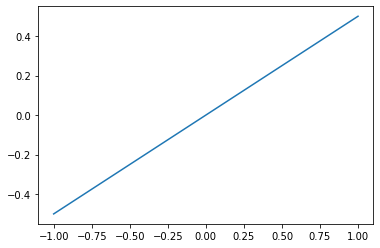

In [2]:
lst = []
thetas = np.linspace(-1,1,20)
for theta in thetas:
    result = minimize_scalar(lambda x: x**2-theta*x)
    x = result.x if result.success else np.nan
    lst.append(x)

plt.plot(thetas, lst)

### Basic optimizaton

In [3]:


result = minimize_scalar(lambda x: x**2 - 4*x)

result
result.x if result.success else np.nan

2.0

### Exercise

For $\theta$ in some grid, find the argmin of $x^2 - \theta x$ and plot it versus $\theta$.

### Multidimensional optimizaton

In [4]:
A = np.identity(2)
A[1, 0] = A[0, 1] = 0.5
b = [-2, -8]

def f(x):
    return b @ x + 0.5 * x @ A @ x

def f1(x):
    return b + A @ x

def f2(x):
    return A

result1 = minimize(f, x0 = np.zeros(2))
result2 = minimize(f, x0=np.zeros(2), jac=f1)
result3 = minimize(f, x0=np.zeros(2), jac=f1, hess=f2)

print(result1.x, result2.x, result3.x)

[-2.66666698  9.33333375] [-2.66666672  9.33333336] [-2.66666672  9.33333336]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


### 3D plotting

In [5]:
def f(x, y):
    u = np.array([x, y])
    return b @ u + 0.5 * u @ A @ u

x = np.linspace(-5, 5, 30)
y = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x, y)

f = np.frompyfunc(f, 2, 1)

Z = f(X, Y)

In [6]:
Z.shape

(30, 30)

In [7]:
"""
fig = plt.figure()
ax = plt.axes(projection='3d')
im = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.colorbar(im)
"""


"\nfig = plt.figure()\nax = plt.axes(projection='3d')\nim = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')\nplt.colorbar(im)\n"

### Contour plot

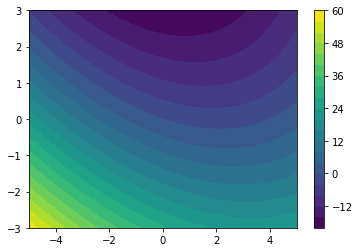

In [8]:
im = plt.contourf(X, Y, Z, 20, cmap='viridis')
plt.colorbar(im)

### Stock return data from Yahoo

In [9]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
prices = pdr(['SPY', 'IEF', 'LQD', 'GLD'], "yahoo")["Adj Close"]
prices.head()

Symbols,SPY,IEF,LQD,GLD
Date,,,,
2017-09-29,230.543365,98.365326,104.402718,121.580002
2017-10-02,231.543610,98.253418,104.500282,120.769997
2017-10-03,232.039185,98.392136,104.733429,120.830002
2017-10-04,232.314453,98.364410,104.672981,121.169998
2017-10-05,233.690948,98.262657,104.526184,120.519997


In [11]:
prices = pdr(['SPY', 'IEF', 'LQD', 'GLD'], "yahoo")["Adj Close"]
prices = prices.sort_index()
prices = prices.resample("M").last()
rets = prices.pct_change()
means = rets.mean().to_numpy()
cov = rets.cov().to_numpy()

### Optimal portfolio

$x_s \geq 0$ is amount saved, $x_b \geq 0$ is amount borrowed (both per \$ invested).  Weights $w \in \mathbb{R}^n$ on risky assets.  Constraint is $x_s + 1_n^\top w = 1 + x_b$.  Expected return is $x_s r_s + w^\top \mu - x_b r_b$.  Variance is $w^\top C w$, where $\mu=$ means and $C=$ covariance matrix.  

Maximize mean - (1/2) * riskaver * variance.  Equivalently, minimize (1/2) * riskaver * variance - mean

### Quadratic programming

minimize a quadratic objective

$$p^\top x + (1/2) x^\top Q x$$

subject to inequality constraints

$$ Gx \le h$$

and equality constraints

$$Ax = b$$

for matrices $Q$, $G$, and $A$ and vectors $p$, $h$, and $b$.

In [12]:
C = cov
raver = 4
rs = 0.02
rb = 0.05

p = np.concatenate(([-rs, rb], -means))
Q = np.zeros((6,6))
Q[2:, 2:] = raver*C

G = np.zeros((2, 6))
G[0,0] = G[1,1] = -1
h = np.zeros(2)

A = np.concatenate(([1, -1], np.ones(4)))
b = np.ones(1)

### Exercise

Define the matrices and vectors for the portfolio choice problem.

### Review: Working with numpy arrays

In [13]:
# means[1:]
# means[1:3]
# means[:-1]
# means.shape

# cov[:, :]
# cov[1:, :]
# cov[2:, 2:]
# cov.shape

# np.ones(3)
# np.zeros(4)
# np.zeros(mean.shape)
# np.identity(3)
# np.zeros((4, 4))
# np.zeros(cov.shape)

# x = np.empty_like(means)
# x[0], x[1], x[2], x[3] = 3, 6, 5, 4
# x



### Solving the portfolio choice problem

Once we have the numpy arrays, use the following:

In [14]:
Q = matrix(Q, (6, 6))
p = matrix(p, (6, 1))
G = matrix(G, (2, 6))
h = matrix(h, (2, 1))
A = matrix(A, (1, 6))
b = matrix(b, (1, 1))

result = qp(Q, p, G, h, A, b)
np.array(result["x"])

     pcost       dcost       gap    pres   dres
 0: -1.4319e-02  1.9034e-02  2e+00  1e+00  1e+00
 1:  1.1228e-02 -6.8403e-02  8e-02  4e-02  4e-02
 2: -5.6272e-02 -9.3449e-02  4e-02  2e-02  2e-02
 3: -1.6207e-01 -2.2463e-01  6e-02  1e-13  1e-17
 4: -1.7492e-01 -1.7632e-01  1e-03  6e-15  6e-18
 5: -1.7502e-01 -1.7503e-01  1e-05  4e-16  7e-18
 6: -1.7502e-01 -1.7502e-01  1e-07  4e-15  1e-17
Optimal solution found.


array([[ 1.70276429e+01],
       [ 3.22107419e-07],
       [-1.19736411e+00],
       [-1.50115994e+01],
       [ 4.43711082e-01],
       [-2.62390209e-01]])

### Solving linear equations

Example: find w such that cov @ w = constant vector and np.sum(w) = 1.

In [15]:
w = np.linalg.solve(cov, np.ones(4))
w = w / np.sum(w)

### Solving nonlinear equations

In [17]:
def f(x):
    return x**2 - 5*x + 4

def f1(x):
    return 2*x - 5

result1 = fsolve(f, x0=0)
result2 = fsolve(f, x0=0, fprime=f1)
result3 = fsolve(f, x0=6)
print(result1, result2, result3)

[1.] [1.] [4.]


### Dynamic programming (cake-eating problem)

maximize

$$\sum_{t=0}^\infty \delta^t \sqrt{c_t}$$

subject to

$$\sum_{t=0}^\infty c_t  \leq 1$$

Dynamic programming: value function $v$, state variable $x$ with $x_{t+1} = x_t - c_t$, $x_0=1$.  Bellman equation:

$$v(x) = \max_{0 \le c \le x} \sqrt{c} + \delta v(x-c)$$

### Value function iteration

Start with an initial guess for $v$ on a grid.  Use it as the right-hand side of the Bellman equation.  Compute the max to get the left-hand side.  Use the new $v$ on the right-hand side and repeat until convergence.

In [18]:

delta = 0.9    # discount rate
grid = np.linspace(0, 1, 100)


A small problem is that to compute the max, we want $v(x-c)$ defined for all $c\leq x$, not just on the grid.  So, we interpolate linearly between grid points.

In [19]:
def rhs(v, x):

    # extend v to be defined on [0,1]
    v = interp1d(grid, v)

    # write maximization objective as minimization objective
    obj = lambda c: - np.sqrt(c) - delta * v(x-c)

    # solve the minimization problem
    result = minimize_scalar(obj, bounds=(0, x), method="bounded")

    # return the value at the optimum
    return - result.fun

Now we can define the contraction map.

In [20]:
def cmap(v):
   
    # convert the rhs function to operate on an array (in x)
    rhs_u = np.frompyfunc(lambda x: rhs(v,x), 1, 1)

    # apply the rhs function to get the LHS of Bellman equation
    newv = rhs_u(grid)

    # return the new v and also how far apart the two v's are
    return newv, np.mean((newv-v)**2)

We iterate on the contraction map until convergence.

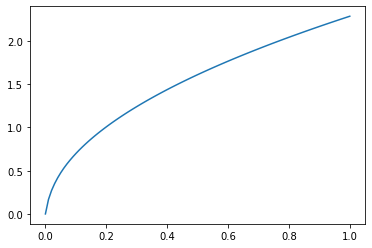

In [21]:
# initialize the iteration
v = np.zeros(len(grid))

# set tolerance and maximum number of iterations
tol = 1.0e-10
maxiters = 100

# initialize error and counter for iterations
err = 1
iter = 0

# run the loop
while (err > tol) and (iter < maxiters):
    v, err = cmap(v)
    iter += 1

plt.plot(grid, v)

To find the optimal decisions at each grid point, we repeat some of the previous code.  optimum is just like rhs except that it returns the argmax instead of the value.  

The analytic optimal policy is $$c^* = (1-\delta^2)x.$$

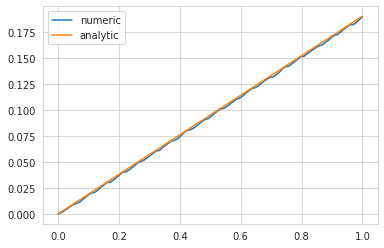

In [22]:
def optimum(v, x):

    # extend v to be defined on [0,1]
    v = interp1d(grid, v)

    # write maximization objective as minimization objective
    obj = lambda c: - np.sqrt(c) - delta * v(x-c)

    # solve the minimization problem
    result = minimize_scalar(obj, bounds=(0, x), method="bounded")

    # return the optimal decision
    return result.x

# optimum_u = np.frompyfunc(lambda x: optimum(v, x), 1, 1)
# c = optimum_u(grid)

c = [optimum(v,x) for x in grid]

cstar = (1-delta**2) * grid

sns.set_style('whitegrid')
plt.plot(grid, c, label="numeric")
plt.plot(grid, cstar, label="analytic")
plt.legend()

### Exercise

Instead of stopping when err <= tol, just iterate $n$ times for $n \in [20, 40, 60, 80, 100]$.  Plot the value function you compute for each $n$, all in the same figure with a legend.  Also, the true value function is known to be
$$v^*(x) = \frac{\sqrt{x}}{\sqrt{1-\delta^2}}$$
Plot it in the same figure.

### Simulating a path of a geometric Brownian motion

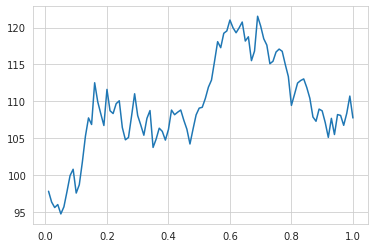

In [23]:
# parameters
mu = 0.05
sigma = 0.2
logdrift = mu - 0.5*sigma**2
X0 = 100

# grid and Brownian shocks
dt = 0.01
grid = np.arange(dt, 1+dt, dt)
dB = norm.rvs(loc=0, scale=np.sqrt(dt), size=len(grid))

# geometric Brownian motion path
X = X0 * np.exp(logdrift*grid + sigma*np.cumsum(dB))

plt.plot(grid, X)

### Valuing a lookback call

Let's compute $E[\max(0, M-K)]$ where $M = max_{0 \leq t \leq T} X_t$.  Take $T=1$.  Start with the value at maturity for a single path.

In [24]:
K = 110

M = np.max(X)
lookback = max(0, M-K)
lookback

11.53065842983554

### Exercise

1.  Write a loop to generate multiple paths and calculate the mean value of the lookback call at maturity.
2.  Do it without a loop.

### AR(1) processes

We will work with
$$ x_t = \phi x_{t-1} + u_t$$

### Exercise

Write a loop to simulate a path of $x$.  Plot it.

### Here is an alternate way to simulate a path.

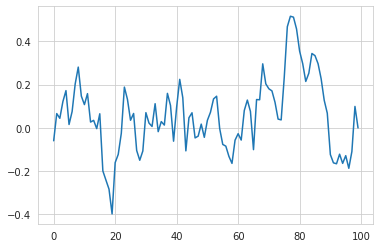

In [25]:
phi, sigma_u = 0.9, 0.1

ar = np.array([1, -phi])
ma = np.array([1])
AR1 = ArmaProcess(ar, ma)
x = AR1.generate_sample(nsample=100, scale=sigma_u)
x = pd.Series(x)
x.plot()


Here are the shocks $u$.  They should be white noise.  The last value will be NaN.

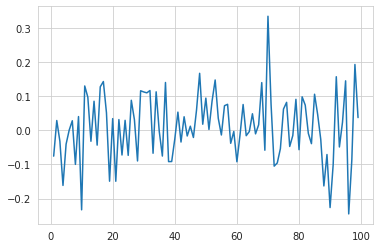

In [33]:
u = x.shift(-1) - phi*x
u.plot()

### Stambaugh bias

Predictive model with an AR(1) regressor:

$$x_{t+1} = \phi x_{t} + u_t$$
$$y_t = \beta x_t + v_t$$


The series $(u_t, v_t)$ is iid in $t$ and joint normal with correlation $\rho$.

Simulate $x$ and $u$.

In [34]:
phi, rho, beta, sigma_u, sigma_v = 0.9, -0.5, 0.5, 0.1, 0.2
nsample = 100

ar = np.array([1, -phi])
ma = np.array([1])
AR1 = ArmaProcess(ar, ma)
x = AR1.generate_sample(nsample=nsample+1, scale=sigma_u)  
x = pd.Series(x)
u = x.shift(-1) - phi*x

x = x.iloc[:-1]
u = u.iloc[:-1]

Simulate $v$ and $y$

In [35]:
e = norm.rvs(size=nsample)
v = sigma_v * (rho*u/sigma_u + np.sqrt(1-rho**2)*e)

y = beta*x + v

Run regression

In [36]:
data = pd.concat((x, y), axis=1)
data.columns = ["x", "y"]
model = smf.ols("y ~ x", data=data)
result = model.fit()
result.params

Intercept    0.013507
x            0.574242
dtype: float64

### Exercise

Put the simulation and regression in a loop.  Run 1,000 times.  Save the betas.  Calculate the distribution and examine bias.  

beta is result.params["x"]